In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Find the control group for store 77,86 and 88 based on:
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [8]:
data = pd.read_csv('QVI_data.csv')

In [9]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [10]:
data['STORE_NBR'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86, 155,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [11]:
data['DATE'] = pd.to_datetime(data['DATE'])
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

In [12]:
data['YEARMONTH'].head()

0    201810
1    201809
2    201903
3    201903
4    201811
Name: YEARMONTH, dtype: int64

In [13]:
def pivot_table(data):
    grouped = data.groupby(['STORE_NBR', 'YEARMONTH'])

    # Precompute values for columns that require custom calculations
    tot_sales = grouped['TOT_SALES'].sum()
    n_customers = grouped['LYLTY_CARD_NBR'].nunique()
    n_txn_per_cust = grouped['TXN_ID'].nunique() / grouped['LYLTY_CARD_NBR'].nunique()
    n_chips_per_txn = grouped['PROD_QTY'].sum() / grouped['TXN_ID'].nunique()
    avg_price_per_unit = grouped['TOT_SALES'].sum() / grouped['PROD_QTY'].sum()

    # Combine all the calculations into a DataFrame
    measures = pd.DataFrame({
        'totSales': tot_sales,
        'nCustomers': n_customers,
        'nTxnPerCust': n_txn_per_cust,
        'nChipsPerTxn': n_chips_per_txn,
        'avgPricePerUnit': avg_price_per_unit
    }).reset_index()

    return measures

In [14]:
monthly_measure = pivot_table(data)

In [15]:
monthly_measure.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [16]:
# Identify stores with full observation periods (exactly 12 months of data)
stores_with_full_obs = (
    monthly_measure.groupby('STORE_NBR')
    .filter(lambda x: len(x) == 12)['STORE_NBR']
    .unique()
)

# Filter pre-trial measures for those stores
pre_trial_measures = monthly_measure[
    (monthly_measure['YEARMONTH'] < 201902) & 
    (monthly_measure['STORE_NBR'].isin(stores_with_full_obs))
]

In [17]:
pre_trial_measures.shape

(1820, 7)

In [18]:
def calculate_and_plot_correlation(input_table, metric_cols:list,stores=[77, 86, 88]):
    corr_matrix = []
    for metric_col in metric_cols:
        pivot_table = input_table.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric_col)
        
        corr = pivot_table.corr()  
        corr = corr[stores]
        corr_matrix.append(corr)
        plt.figure(figsize=(20, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlation Matrix for {metric_col}')
        plt.show()
    return corr_matrix

In [19]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """
    Calculate standardized magnitude distances between a comparison store and all other stores.

    Parameters:
    - input_table (pd.DataFrame): Input data containing store metrics.
    - metric_col (str): The column name for the metric to compare.
    - store_comparison (int): The store number to compare against.

    Returns:
    - pd.DataFrame: A DataFrame with standardized magnitude distances.
    """
    # Initialize an empty list to store results
    distance_results = []

    # Get unique store numbers
    store_numbers = input_table['STORE_NBR'].unique()

    # Loop through each store
    for store in store_numbers:
        # Extract data for the comparison store and the current store
        store_comparison_data = input_table[input_table['STORE_NBR'] == store_comparison][['YEARMONTH', metric_col]]
        current_store_data = input_table[input_table['STORE_NBR'] == store][['YEARMONTH', metric_col]]

        # Merge data on YEARMONTH to align them for comparison
        merged_data = pd.merge(
            store_comparison_data,
            current_store_data,
            on='YEARMONTH',
            suffixes=('_comparison', '_current')
        )

        # Calculate absolute differences for the metric
        merged_data['measure'] = abs(
            merged_data[f'{metric_col}_comparison'] - merged_data[f'{metric_col}_current']
        )

        # Append the results
        for _, row in merged_data.iterrows():
            distance_results.append({
                'Store1': store_comparison,
                'Store2': store,
                'YEARMONTH': row['YEARMONTH'],
                'measure': row['measure']
            })

    # Convert results to a DataFrame
    calc_dist_table = pd.DataFrame(distance_results)

    # Standardize the magnitude distances (range 0 to 1)
    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    calc_dist_table = calc_dist_table.merge(min_max_dist, on=['Store1', 'YEARMONTH'])
    calc_dist_table['magnitudeMeasure'] = 1 - (calc_dist_table['measure'] - calc_dist_table['min']) / (calc_dist_table['max'] - calc_dist_table['min'])
    # Because want to merge with correlation (the higher the closer), so use 1- to change the distance
    
    # Calculate the average magnitude measure for each store pair
    final_dist_table = calc_dist_table.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)

    return final_dist_table

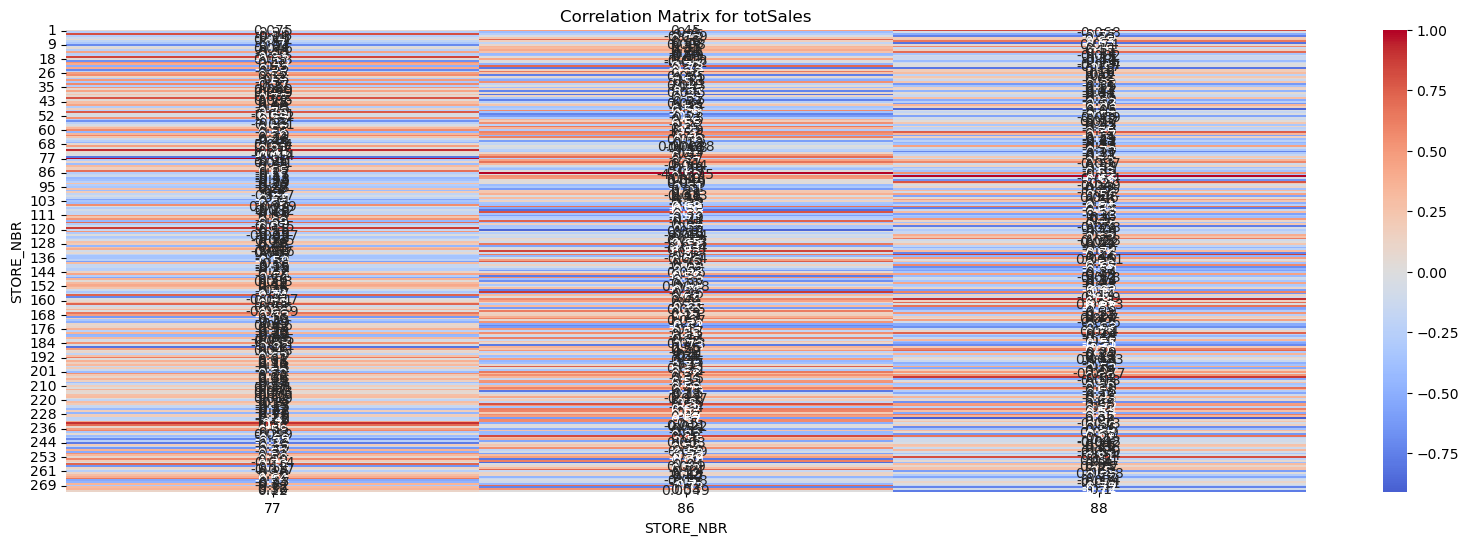

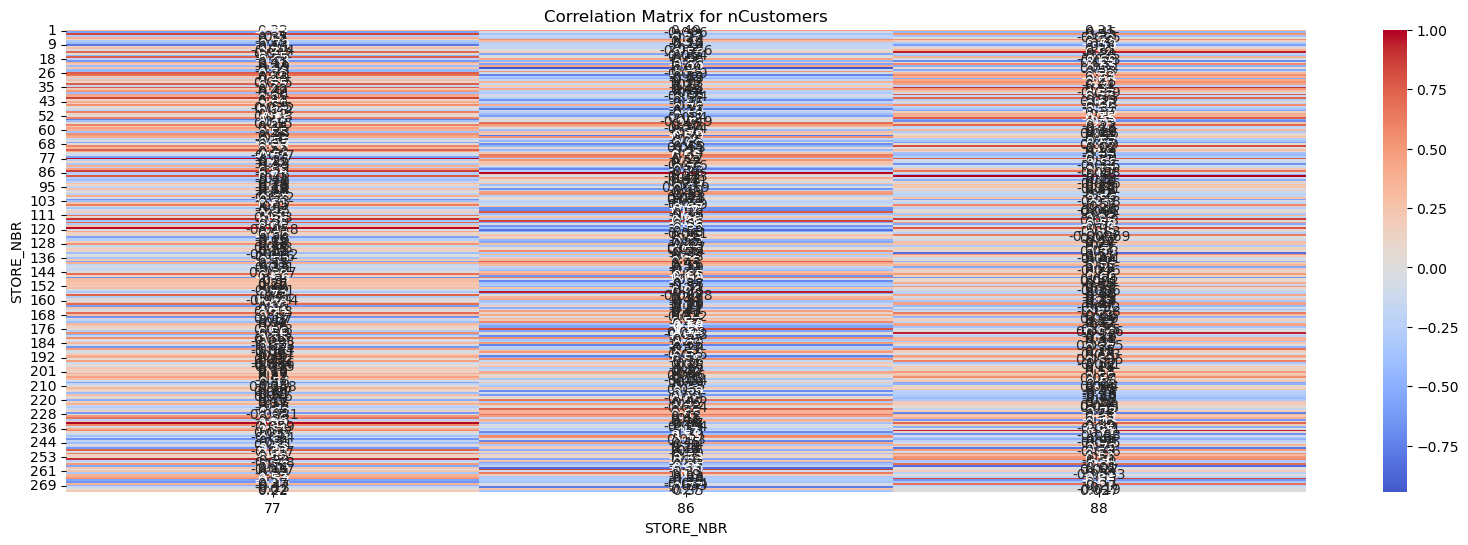

In [20]:
corr_matrix = calculate_and_plot_correlation(pre_trial_measures, ['totSales', 'nCustomers'])

In [21]:
sales_corr = corr_matrix[0]
customer_corr = corr_matrix[1]

In [22]:
score_Control = (sales_corr + customer_corr) / 2

For store 77, the most similar store is 233

In [23]:
score_Control[77].sort_values(ascending=False)

STORE_NBR
77     1.000000
233    0.947066
119    0.925466
71     0.834461
3      0.820426
         ...   
19    -0.655691
242   -0.668008
75    -0.698743
186   -0.728090
9     -0.744338
Name: 77, Length: 260, dtype: float64

For store 86, the most similar store is store 155

In [24]:
score_Control[86].sort_values(ascending=False)

STORE_NBR
86     1.000000
155    0.910379
114    0.794877
260    0.783426
109    0.779539
         ...   
270   -0.748973
185   -0.759336
108   -0.768829
120   -0.843895
23    -0.864128
Name: 86, Length: 260, dtype: float64

For store 88, the most similar store is store 178

In [25]:
score_Control[88].sort_values(ascending=False)

STORE_NBR
88     1.000000
178    0.835661
14     0.820767
204    0.718018
134    0.686587
         ...   
48    -0.609324
141   -0.618994
227   -0.633695
239   -0.651501
133   -0.785417
Name: 88, Length: 260, dtype: float64

In [26]:
dist_77 = calculate_magnitude_distance(pre_trial_measures, 'totSales', 77).sort_values('mag_measure', ascending=False)
dist_86 = calculate_magnitude_distance(pre_trial_measures, 'totSales', 86).sort_values('mag_measure', ascending=False)
dist_88 = calculate_magnitude_distance(pre_trial_measures, 'totSales', 88).sort_values('mag_measure', ascending=False)

In [27]:
dist_77.head()

,Store1,Store2,mag_measure
72,77,77,1.000000
221,77,233,0.985265
242,77,255,0.976721
49,77,53,0.975422
180,77,188,0.975177


In [28]:
score_Control_77=pd.DataFrame(score_Control[77]).reset_index()
score_Control_77.columns=['STORE_NBR','Correlation']

In [29]:
score_Control_86=pd.DataFrame(score_Control[86]).reset_index()
score_Control_86.columns=['STORE_NBR','Correlation']

score_Control_88=pd.DataFrame(score_Control[88]).reset_index()
score_Control_88.columns=['STORE_NBR','Correlation']

In [30]:
score_77 = pd.merge(score_Control_77, dist_77, left_on=['STORE_NBR'], right_on=['Store2'])

In [31]:
score_86 = pd.merge(score_Control_86, dist_86, left_on=['STORE_NBR'], right_on=['Store2'])
score_88 = pd.merge(score_Control_88, dist_88, left_on=['STORE_NBR'], right_on=['Store2'])

In [32]:
score_77['weighted_score'] = (score_77['Correlation'] + score_77['mag_measure'])/2
score_86['weighted_score'] = (score_86['Correlation'] + score_86['mag_measure'])/2
score_88['weighted_score'] = (score_88['Correlation'] + score_88['mag_measure'])/2

In [33]:
score_77.sort_values('weighted_score', ascending=False).head(3)

,STORE_NBR,Correlation,Store1,Store2,mag_measure,weighted_score
72,77,1.000000,77,77,1.000000,1.000000
221,233,0.947066,77,233,0.985265,0.966165
38,41,0.813726,77,41,0.965140,0.889433


In [34]:
score_86.sort_values('weighted_score', ascending=False).head(3)

,STORE_NBR,Correlation,Store1,Store2,mag_measure,weighted_score
80,86,1.000000,86,86,1.000000,1.000000
147,155,0.910379,86,155,0.962964,0.936671
102,109,0.779539,86,109,0.961985,0.870762


In [35]:
score_88.sort_values('weighted_score', ascending=False).head(3)

,STORE_NBR,Correlation,Store1,Store2,mag_measure,weighted_score
82,88,1.000000,88,88,1.000000,1.000000
225,237,0.627903,88,237,0.956076,0.791989
170,178,0.835661,88,178,0.695854,0.765758


The most similar store for 88 is store 237

### PLOT

In [36]:
measureOverTimeSales = monthly_measure.copy()
measureOverTimeSales['Store_type_77'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 77 else ('Control' if x == 233 else 'Other stores')
)
measureOverTimeSales['Store_type_86'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 86 else ('Control' if x == 155 else 'Other stores')
)
measureOverTimeSales['Store_type_88'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 88 else ('Control' if x == 178 else 'Other stores')
)

In [37]:
def plot_trends_for_store(data, trial_store, control_store, measure_col, ylabel, title):
    # Create a Store_type column for the specific trial and control stores
    data['Store_type'] = data['STORE_NBR'].apply(
        lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
    )
    
    # Calculate mean measure for each 'YEARMONTH' and 'Store_type'
    grouped_data = data.groupby(['YEARMONTH', 'Store_type']).agg(
        measure_mean=(measure_col, 'mean')
    ).reset_index()
 
    grouped_data['TransactionMonth'] = pd.to_datetime(grouped_data['YEARMONTH'], format='%Y%m')
    
    # Plot the trends
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_data, x='TransactionMonth', y='measure_mean', hue='Store_type')
    
    plt.title(title)
    plt.xlabel('Month of Operation')
    plt.ylabel(ylabel)
    plt.legend(title='Store Type')
    plt.grid(True)
    plt.show()


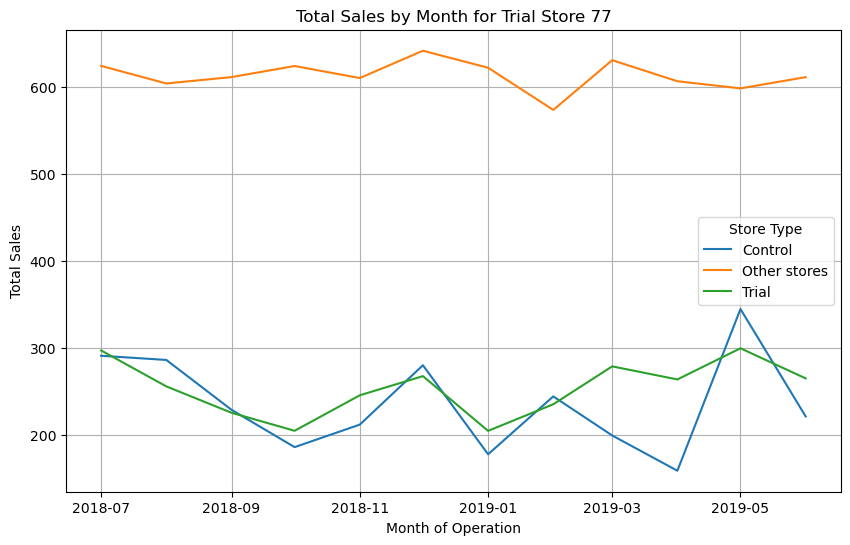

In [38]:
plot_trends_for_store(
    measureOverTimeSales, 77, 233, 'totSales', 
    ylabel='Total Sales', 
    title='Total Sales by Month for Trial Store 77'
)

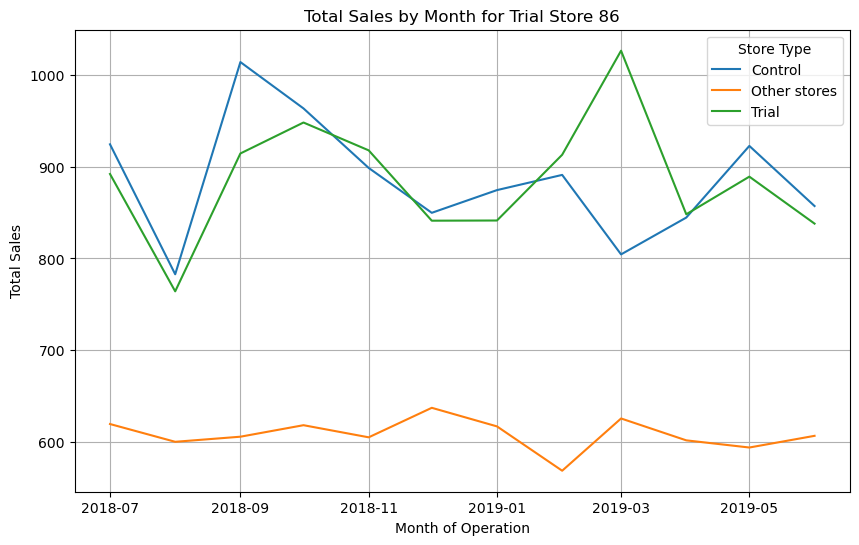

In [39]:
plot_trends_for_store(
    measureOverTimeSales, 86, 155, 'totSales', 
    ylabel='Total Sales', 
    title='Total Sales by Month for Trial Store 86'
)

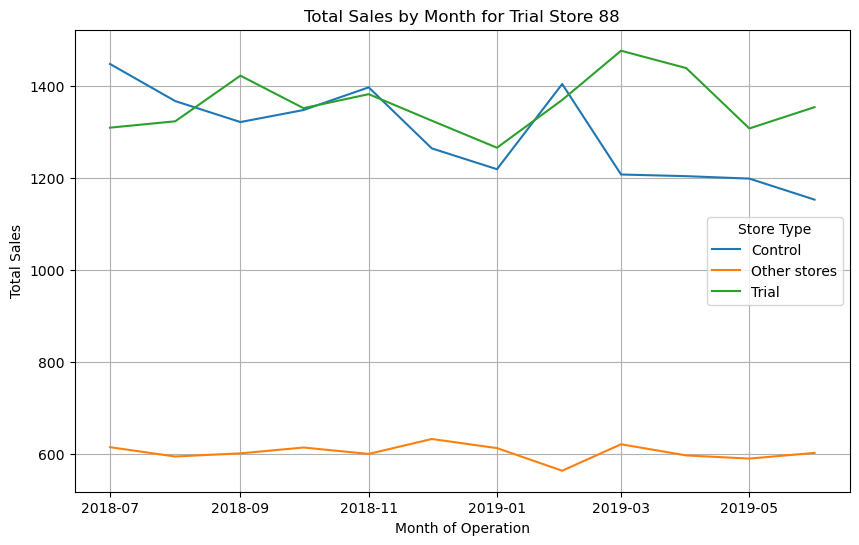

In [40]:
plot_trends_for_store(
    measureOverTimeSales, 88, 237, 'totSales', 
    ylabel='Total Sales', 
    title='Total Sales by Month for Trial Store 88'
)

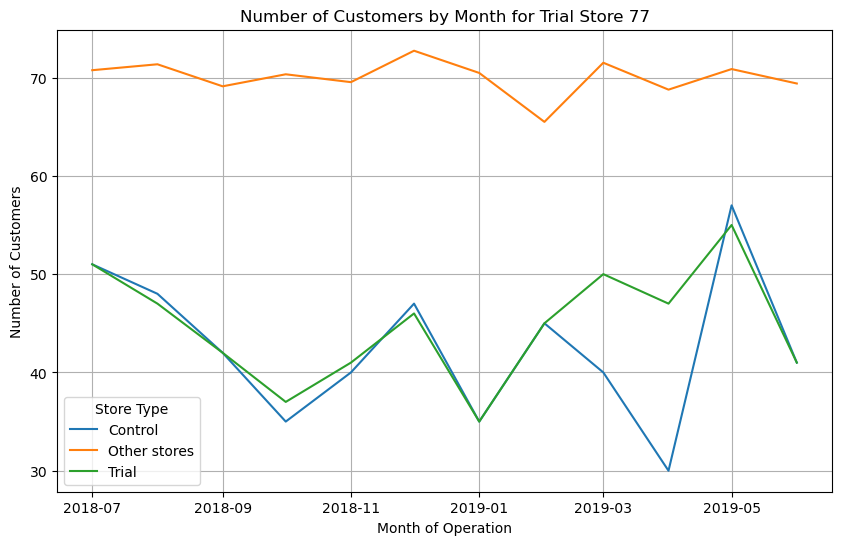

In [41]:
plot_trends_for_store(
    measureOverTimeSales, 77, 233, 'nCustomers', 
    ylabel='Number of Customers', 
    title='Number of Customers by Month for Trial Store 77'
)

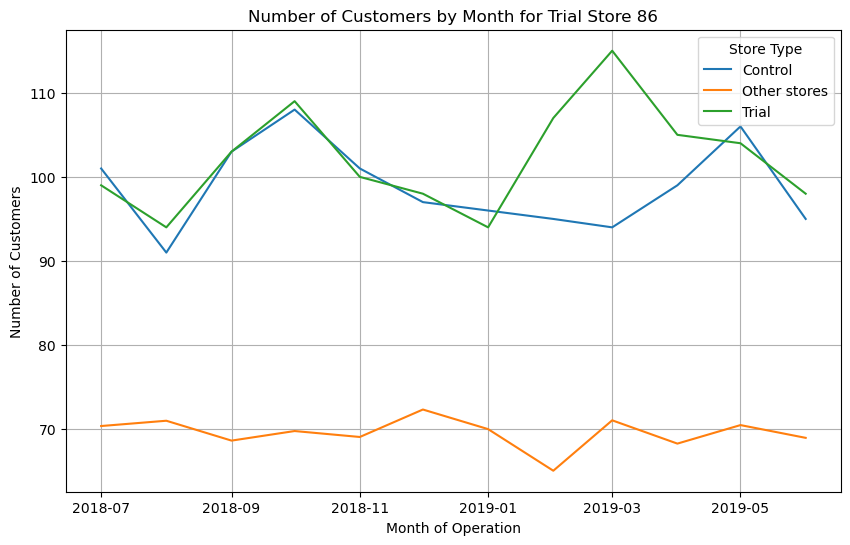

In [42]:
plot_trends_for_store(
    measureOverTimeSales, 86, 155, 'nCustomers', 
    ylabel='Number of Customers', 
    title='Number of Customers by Month for Trial Store 86'
)

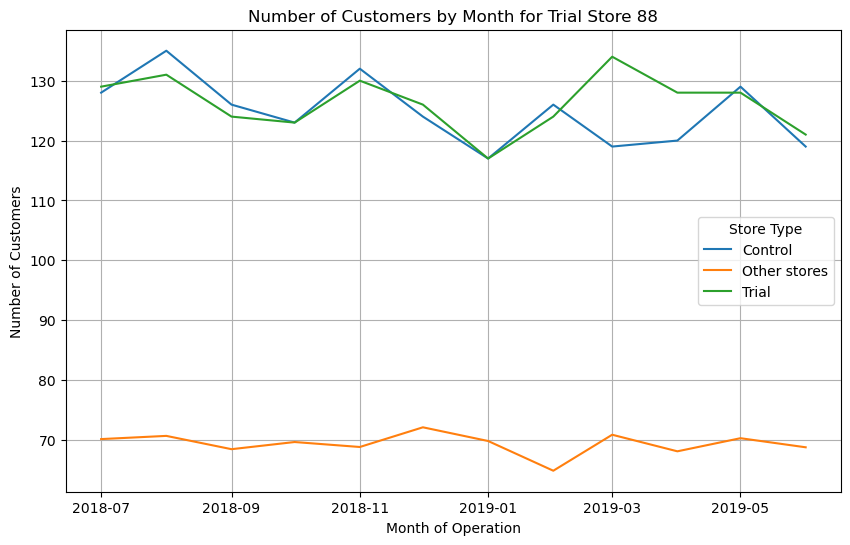

In [43]:
plot_trends_for_store(
    measureOverTimeSales, 88, 237, 'nCustomers', 
    ylabel='Number of Customers', 
    title='Number of Customers by Month for Trial Store 88'
)

Now that everything looks good, we’ve identified control stores 233, 155, and 237 for trial stores 77, 86, and 88, respectively. These control stores were selected due to their similar patterns in average monthly sales and average number of customers before the trial period.

## Compare experiment effects

Test- store77  
Control- store233

In [46]:
pre_trial_measures.columns

Index(['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers', 'nTxnPerCust',
       'nChipsPerTxn', 'avgPricePerUnit'],
      dtype='object')

In [44]:
trial_store = 77
control_store = 233

In [47]:
# Before trail: trial store sales / control store sales (sales relative to the control store)
scaling_factor = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & 
                       (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & 
                       (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()
)
# 
monthly_measure['controlSales'] = np.where(
    monthly_measure['STORE_NBR'] == control_store,
    monthly_measure['totSales'] * scaling_factor,
    np.nan
)

percentage_diff = monthly_measure.loc[monthly_measure['STORE_NBR'] == control_store, 
                                      ['YEARMONTH', 'controlSales']].merge(
    monthly_measure.loc[monthly_measure['STORE_NBR'] == trial_store, ['YEARMONTH', 'totSales']],
    on='YEARMONTH'
)
percentage_diff['percentageDiff'] = abs(percentage_diff['controlSales'] - percentage_diff['totSales']) / percentage_diff['controlSales']

In [52]:
std_dev = percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'].std()

monthly_measure['Store_type'] = np.where(
    monthly_measure['STORE_NBR'] == trial_store, "Trial",
    np.where(monthly_measure['STORE_NBR'] == control_store, "Control", "Other stores")
)
past_sales = monthly_measure.groupby(['YEARMONTH', 'Store_type']).agg(
    totSales=('totSales', 'mean')
).reset_index()

past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str).str[:4] + '-' + 
    past_sales['YEARMONTH'].astype(str).str[4:] + '-01'
)

# Confidence intervals
control_95 = past_sales[past_sales['Store_type'] == "Control"].copy()
control_95['totSales'] *= (1 + std_dev * 2)
control_95['Store_type'] = "Control 95th % confidence interval"

control_5 = past_sales[past_sales['Store_type'] == "Control"].copy()
control_5['totSales'] *= (1 - std_dev * 2)
control_5['Store_type'] = "Control 5th % confidence interval"

trial_assessment = pd.concat([past_sales, control_95, control_5])


In [58]:
trial_assessment.head()

,YEARMONTH,Store_type,totSales,TransactionMonth
0,201807,Control,290.700000,2018-07-01
1,201807,Other stores,623.817424,2018-07-01
2,201807,Trial,296.800000,2018-07-01
3,201808,Control,285.900000,2018-08-01
4,201808,Other stores,603.600192,2018-08-01


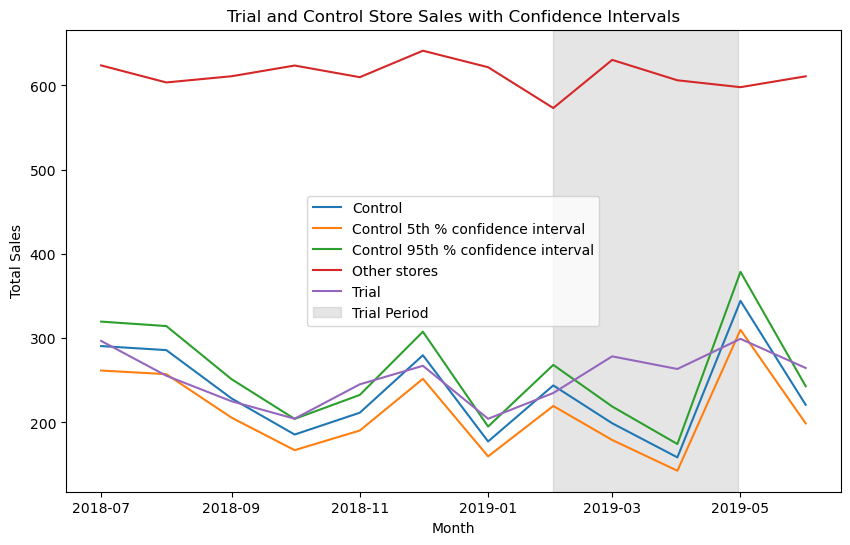

In [57]:
plt.figure(figsize=(10, 6))
for label, group in trial_assessment.groupby('Store_type'):
    plt.plot(group['TransactionMonth'], group['totSales'], label=label)
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='gray', alpha=0.2, label="Trial Period")
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Trial and Control Store Sales with Confidence Intervals')
plt.legend()
plt.show()

A significant increase in sales can be seen for store 77 in two of the three trial months.

---
Test- store86  
Control- store155

In [ ]:
# trial_store = 86
# control_store = 233

In [62]:
def visulize_trial_results(trial_store, control_store):
    trial_store = trial_store
    control_store = control_store
    
    scaling_factor = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & 
                       (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & 
                       (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()
    )
# 
    monthly_measure['controlSales'] = np.where(
        monthly_measure['STORE_NBR'] == control_store,
        monthly_measure['totSales'] * scaling_factor,
        np.nan
    )

    percentage_diff = monthly_measure.loc[monthly_measure['STORE_NBR'] == control_store, 
                                        ['YEARMONTH', 'controlSales']].merge(
        monthly_measure.loc[monthly_measure['STORE_NBR'] == trial_store, ['YEARMONTH', 'totSales']],
        on='YEARMONTH'
    )
    percentage_diff['percentageDiff'] = abs(percentage_diff['controlSales'] - percentage_diff['totSales']) / percentage_diff['controlSales']

    std_dev = percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'].std()

    monthly_measure['Store_type'] = np.where(
        monthly_measure['STORE_NBR'] == trial_store, "Trial",
        np.where(monthly_measure['STORE_NBR'] == control_store, "Control", "Other stores")
    )
    past_sales = monthly_measure.groupby(['YEARMONTH', 'Store_type']).agg(
        totSales=('totSales', 'mean')
    ).reset_index()

    past_sales['TransactionMonth'] = pd.to_datetime(
        past_sales['YEARMONTH'].astype(str).str[:4] + '-' + 
        past_sales['YEARMONTH'].astype(str).str[4:] + '-01'
    )

    # Confidence intervals
    control_95 = past_sales[past_sales['Store_type'] == "Control"].copy()
    control_95['totSales'] *= (1 + std_dev * 2)
    control_95['Store_type'] = "Control 95th % confidence interval"

    control_5 = past_sales[past_sales['Store_type'] == "Control"].copy()
    control_5['totSales'] *= (1 - std_dev * 2)
    control_5['Store_type'] = "Control 5th % confidence interval"

    trial_assessment = pd.concat([past_sales, control_95, control_5])

    plt.figure(figsize=(10, 6))
    for label, group in trial_assessment.groupby('Store_type'):
        plt.plot(group['TransactionMonth'], group['totSales'], label=label)
    plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='gray', alpha=0.2, label="Trial Period")
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.title('Trial and Control Store Sales with Confidence Intervals')
    plt.legend()
    plt.show()

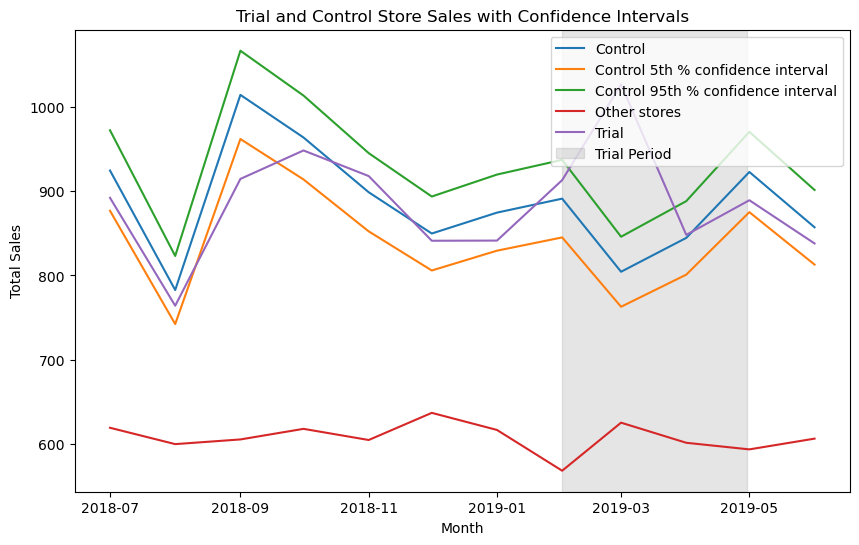

In [63]:
visulize_trial_results(86, 155)

The trial in store 86 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.

---
Test- store88  
Control- store237

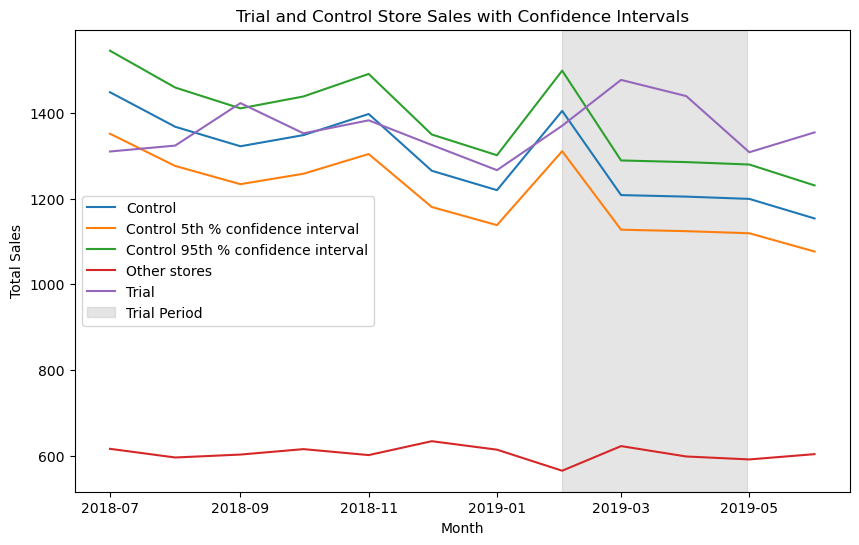

In [64]:
visulize_trial_results(88, 237)

The trial in store 88 is significantly different to its control store in the trial period as the
trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the
three trial months.

---
We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86. We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.